# Binary classification

The main objective of the predictive analysis is to find potential dropout so that support could be extended. This is best done through a binary classifcation.

We label all with Dropout as target as 1 and others as 0. 

**Metric**

We are interested in capturing all the potential dropouts. So the preffered metric to look for would be Recall.

In [3]:
#import libraries

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

from sklearn.model_selection import StratifiedShuffleSplit, cross_validate, GridSearchCV, train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, recall_score, accuracy_score

from sklearn import set_config

from xgboost import XGBClassifier

import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline as imb_pipeline
from imblearn.over_sampling import SMOTENC

In [4]:
train = pd.read_csv("./../data/2_final/train.csv")
test =  pd.read_csv("./../data/2_final/test.csv")

In [5]:
features_to_include = ['Marital status', 'Application mode', 'Application order', 'Course',
       'Attendance_mode', 'Previous qualification (grade)', 'Admission grade', 'Displaced', 
       'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International', 'father_occ', 'mother_occ', 'father_qual', 'mother_qual', 'previous_qual',
        'Target']

In [6]:
train_df = train[features_to_include]
test_df = test[features_to_include]

In [7]:
y_train = train_df["Target"]
X_train = train_df.drop("Target", axis=1)

y_test = test_df["Target"]
X_test = test_df.drop("Target", axis=1)

## Changing labels to binary

In [8]:
y_train = np.where(y_train == 'Dropout', 1, 0)
y_test = np.where(y_test == 'Dropout', 1, 0)


## Preprocessing

In [9]:
cat_features = ['Course', 'previous_qual', 'Debtor', 'Gender', 'Scholarship holder', 'father_occ', 'mother_occ', 'father_qual', 'mother_qual', 'Marital status', 'Application mode', 'Attendance_mode', 'International', 'Displaced']
num_features = ['Previous qualification (grade)', 'Admission grade', 'Age at enrollment', 'Application order']

In [10]:
select_cat_features = ColumnTransformer([('select_cat', 'passthrough', cat_features)])
cat_transformers = Pipeline([('selector', select_cat_features),
                            ('onehot', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
                            ])

                            
select_num_features = ColumnTransformer([('select_num', 'passthrough', num_features)])


preprocess_pipe = FeatureUnion([('cat', cat_transformers),
                                ('num', select_num_features)
                                ])

In [11]:
class Model:
    def __init__(self, model_name, estimator, preprocessor=None, scoring=None, cv=5, sampler = None, random_state=42):
        self.name = model_name
        self.estimator = estimator
        self.preprocess = preprocessor
        self.scoring = scoring
        self.cv = cv
        self.rs = random_state
        self.sampler = sampler

    def make_model_pipeline(self):
        if self.sampler == None:
            self.model = Pipeline([('preprocess', self.preprocess),
                                ('model', self.estimator)])
        else:
            self.model = imb_pipeline([('sampler', self.sampler),
                                    ('preprocess', self.preprocess),
                                    ('model', self.estimator)])


    def train(self, X_train, y_train):
        '''Trains the  model
        Args:
            X_train: Training data feature matrix
            y_train: Training data label vector
            
        Returns:
            trained model
        '''
        self.make_model_pipeline()

        
        self.cv_results = cross_validate(self.model, X_train, y_train, cv=self.cv, scoring=self.scoring, return_train_score=True)

        mean_train_score = self.cv_results["train_score"].mean()
        mean_val_score = self.cv_results["test_score"].mean()
        
        std_train_score = self.cv_results["train_score"].std()
        std_val_score = self.cv_results["test_score"].std()

        print(f"Cross validated training results for {self.name} model")
        print("---------------------------------------------------------")
        print(f"Train score: {mean_train_score} +/- {std_train_score}" )
        print(f"Validation score: {mean_val_score} +/- {std_val_score}" )

        self.fitted_model = self.model.fit(X_train, y_train)

    def evaluate(self, X_test, y_test):
        y_pred = self.fitted_model.predict(X_test)

        recall = recall_score(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)
        print("Recall score on test set: ", recall)
        print("Accuracy score on test set: ", acc)
        print()
        print(classification_report(y_test, y_pred))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    
    def tune(self, param_grid, X_train, y_train):
        '''Do hyper parameter tuning using GridSearch strategy
        
        Args:
            model: Model to be tuned
            param_grid: dict of parameters
            X_train: Feature matrix
            y_train: Label matrix
            
        Returns: 
            best parameters
            best estimator
        '''

        self.make_model_pipeline()
        search = GridSearchCV(self.model, param_grid = param_grid,
                            cv = self.cv,
                            scoring=self.scoring,
                            return_train_score=True)
        
        search.fit(X_train, y_train)
        
        print("Best parameters: ", search.best_params_)
        
        print("-------------------Best model performance --------------------------")
        
        mean_train_score = search.cv_results_['mean_train_score'][search.best_index_]
        mean_val_score = search.cv_results_['mean_test_score'][search.best_index_]
        std_train_score = search.cv_results_['std_train_score'][search.best_index_]
        std_val_score = search.cv_results_['std_test_score'][search.best_index_]

        print(f"Score of the model on the train set:\n"
            f"{mean_train_score:.3f} +/- {std_train_score:.6f}")

        print(f"Score of the model on the validation set:\n"
            f"{mean_val_score:.3f} +/- {std_val_score:.6f}")
        
        self.fitted_model = search.best_estimator_

In [12]:
##Let's supress sklearn warnings

def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

In [13]:
## Cross validation scheme

cv = StratifiedShuffleSplit(n_splits = 5, test_size=0.2, random_state=32)

### Baseline model

We know that the dropout rate is 32%. The simplest baseline would be one where the 32% of the samples are randomly assigned the label 1.

In [212]:
baseline_clf = Model(model_name="Baseline classifier", 
                    estimator=DummyClassifier(strategy='stratified'),
                    preprocessor=preprocess_pipe,
                    scoring="recall",
                    cv = cv,
                    random_state=32)

In [213]:
baseline_clf.train(X_train, y_train)

Cross validated training results for Baseline classifier model
---------------------------------------------------------
Train score: 0.32285714285714284 +/- 0.016944470564744064
Validation score: 0.32599118942731276 +/- 0.008810572687224683


Recall score on test set:  0.27816901408450706
Accuracy score on test set:  0.5423728813559322

              precision    recall  f1-score   support

           0       0.66      0.67      0.66       601
           1       0.28      0.28      0.28       284

    accuracy                           0.54       885
   macro avg       0.47      0.47      0.47       885
weighted avg       0.54      0.54      0.54       885



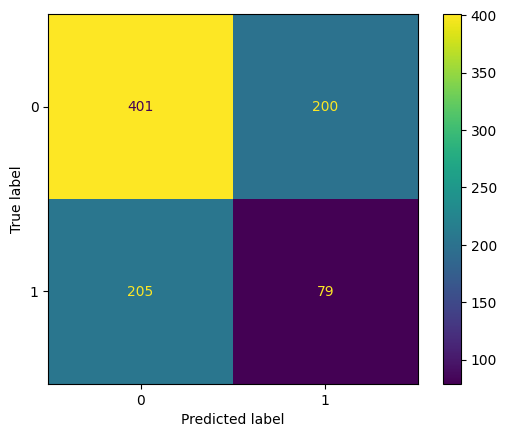

In [214]:
baseline_clf.evaluate(X_test, y_test)

### Logistic Regression

In [223]:
logistic_clf = Model(model_name="Logistic Regression", 
                    estimator=LogisticRegression(penalty = "elasticnet", solver="saga", l1_ratio=0,  max_iter=1000),
                    preprocessor=preprocess_pipe,
                    scoring="recall",
                    cv = cv,
                    random_state=32)

In [224]:
logistic_clf.train(X_train, y_train)

Cross validated training results for Logistic Regression model
---------------------------------------------------------
Train score: 0.3767032967032967 +/- 0.014864033774866727
Validation score: 0.3788546255506608 +/- 0.03423675634841488


In [225]:
param_grid = {"model__C": [0.01, 0.1, 1, 10, 100],
            "model__l1_ratio": np.linspace(0, 1, 11)}
logistic_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__C': 1, 'model__l1_ratio': 0.0}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.377 +/- 0.015391
Score of the model on the validation set:
0.379 +/- 0.034237


Recall score on test set:  0.4014084507042254
Accuracy score on test set:  0.7333333333333333

              precision    recall  f1-score   support

           0       0.76      0.89      0.82       601
           1       0.63      0.40      0.49       284

    accuracy                           0.73       885
   macro avg       0.70      0.65      0.66       885
weighted avg       0.72      0.73      0.71       885



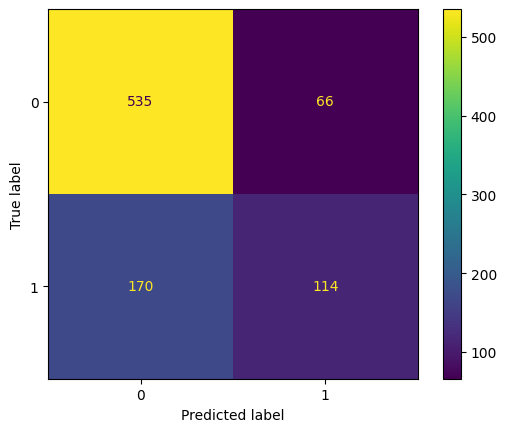

In [226]:
logistic_clf.evaluate(X_test, y_test)

### Ridge classifier

In [227]:
ridge_clf = Model(model_name = "Ridge classifier", 
                    estimator = RidgeClassifier(),
                    preprocessor = preprocess_pipe,
                    scoring = "recall",
                    random_state = 32)

In [228]:
ridge_clf.train(X_train, y_train)

Cross validated training results for Ridge classifier model
---------------------------------------------------------
Train score: 0.3718084116103918 +/- 0.011087522529933563
Validation score: 0.35885694412242064 +/- 0.030457710141513602


In [229]:
param_grid = {"model__alpha": [0.01, 0.1, 1, 10, 100]}
ridge_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__alpha': 0.01}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.372 +/- 0.011088
Score of the model on the validation set:
0.359 +/- 0.030458


Recall score on test set:  0.36971830985915494
Accuracy score on test set:  0.7288135593220338

              precision    recall  f1-score   support

           0       0.75      0.90      0.82       601
           1       0.63      0.37      0.47       284

    accuracy                           0.73       885
   macro avg       0.69      0.63      0.64       885
weighted avg       0.71      0.73      0.71       885



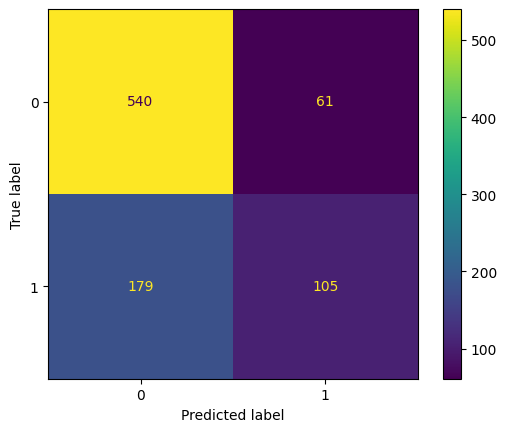

In [230]:
ridge_clf.evaluate(X_test, y_test)

### Support vector machine

In [231]:
svm_clf = Model(model_name = "SVM classifier", 
                    estimator = LinearSVC(loss='hinge'),
                    preprocessor = preprocess_pipe,
                    scoring = "recall",
                    random_state = 32)

In [232]:
svm_clf.train(X_train, y_train)

Cross validated training results for SVM classifier model
---------------------------------------------------------
Train score: 0.6268056915581668 +/- 0.4399018751024103
Validation score: 0.6264626323518045 +/- 0.4400181644122451


In [233]:
param_grid = {"model__penalty": ["l1", "l2"],
                "model__C": [0.001, 0.01, 0.1, 1, 10, 100]}
svm_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__C': 1, 'model__penalty': 'l2'}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.645 +/- 0.419975
Score of the model on the validation set:
0.641 +/- 0.425385


Recall score on test set:  0.22183098591549297
Accuracy score on test set:  0.7175141242937854

              precision    recall  f1-score   support

           0       0.72      0.95      0.82       601
           1       0.68      0.22      0.34       284

    accuracy                           0.72       885
   macro avg       0.70      0.59      0.58       885
weighted avg       0.71      0.72      0.66       885



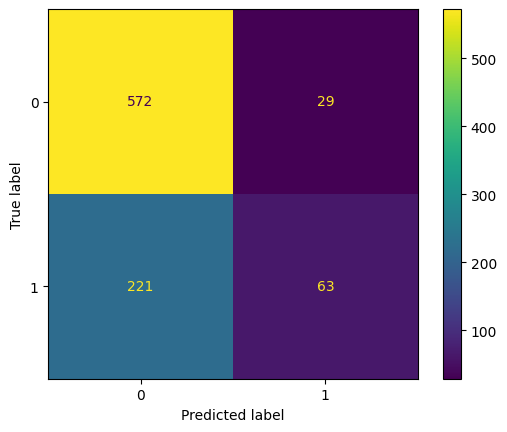

In [234]:
svm_clf.evaluate(X_test, y_test)

### Decision tree 

In [235]:
tree_clf = Model(model_name = "Decision tree classifier", 
                    estimator = DecisionTreeClassifier(),
                    preprocessor = preprocess_pipe,
                    scoring = "recall",
                    random_state = 32)

In [236]:
tree_clf.train(X_train, y_train)

Cross validated training results for Decision tree classifier model
---------------------------------------------------------
Train score: 1.0 +/- 0.0
Validation score: 0.4854780122111446 +/- 0.03379608005345253


In [237]:
param_grid = {"model__max_depth": [2, 3, 4, 5, 10],
                "model__min_samples_split":[2, 4, 6, 8, 10],
                "model__min_samples_leaf": [1, 2, 3, 6, 7, 8]}

tree_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__max_depth': 2, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.499 +/- 0.145449
Score of the model on the validation set:
0.501 +/- 0.125472


In [312]:
param_grid = {"model__ccp_alpha": [0.005, 0.01, 0.05, 0.1, 0],
                "model__min_samples_split":[2, 4, 6, 8, 10],
                "model__min_samples_leaf": [1, 2, 3, 4, 5]}

tree_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__ccp_alpha': 0.01, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.594 +/- 0.012335
Score of the model on the validation set:
0.589 +/- 0.024439


Recall score on test set:  0.5880281690140845
Accuracy score on test set:  0.6813559322033899

              precision    recall  f1-score   support

           0       0.79      0.73      0.76       601
           1       0.50      0.59      0.54       284

    accuracy                           0.68       885
   macro avg       0.65      0.66      0.65       885
weighted avg       0.70      0.68      0.69       885



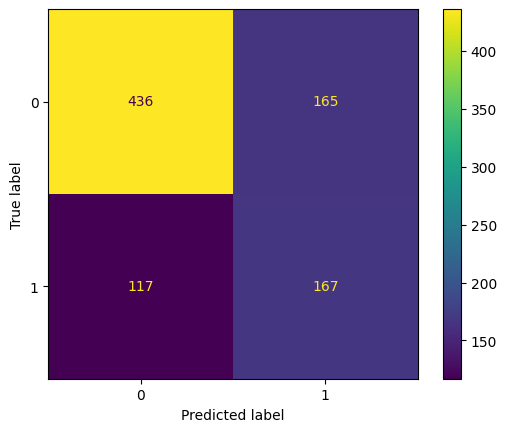

In [313]:
tree_clf.evaluate(X_test, y_test)

### Random Forest

In [239]:
rf_clf = Model(model_name = "Random forest classifier", 
                    estimator = RandomForestClassifier(),
                    preprocessor = preprocess_pipe,
                    scoring = "recall",
                    random_state = 32)

In [240]:
rf_clf.train(X_train, y_train)

Cross validated training results for Random forest classifier model
---------------------------------------------------------
Train score: 1.0 +/- 0.0
Validation score: 0.4309915758559394 +/- 0.04097830001868792


In [321]:
param_grid = {"model__n_estimators": [50, 100, 150, 200],
                "model__max_depth": [2, 10, 15, 20, 25],
                "model__min_samples_split":[2, 3, 4, 5],
                "model__min_samples_leaf": [1, 2, 3, 4, 5]}

rf_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 150}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.913 +/- 0.007976
Score of the model on the validation set:
0.460 +/- 0.035866


Recall score on test set:  0.40492957746478875
Accuracy score on test set:  0.7209039548022599

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       601
           1       0.60      0.40      0.48       284

    accuracy                           0.72       885
   macro avg       0.68      0.64      0.65       885
weighted avg       0.70      0.72      0.70       885



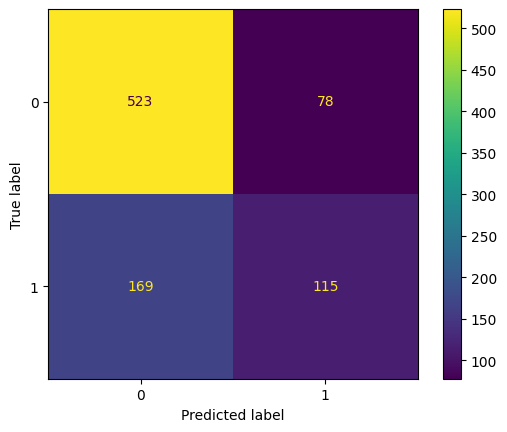

In [322]:
rf_clf.evaluate(X_test, y_test)

### Gradient boosting

In [252]:
gboost_clf = Model(model_name = "Gradient boosting classifier", 
                    estimator = GradientBoostingClassifier(),
                    preprocessor = preprocess_pipe,
                    scoring = "recall",
                    random_state = 32)

In [253]:
gboost_clf.train(X_train, y_train)

Cross validated training results for Gradient boosting classifier model
---------------------------------------------------------
Train score: 0.545954133874926 +/- 0.009233278036331399
Validation score: 0.4547260221037175 +/- 0.03385200876503668


In [259]:
param_grid = {"model__n_estimators": [100, 200, 300, 400, 450, 500, 550]}

gboost_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__n_estimators': 500}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.731 +/- 0.004275
Score of the model on the validation set:
0.493 +/- 0.023550


Recall score on test set:  0.47183098591549294
Accuracy score on test set:  0.7231638418079096

              precision    recall  f1-score   support

           0       0.77      0.84      0.81       601
           1       0.59      0.47      0.52       284

    accuracy                           0.72       885
   macro avg       0.68      0.66      0.66       885
weighted avg       0.71      0.72      0.71       885



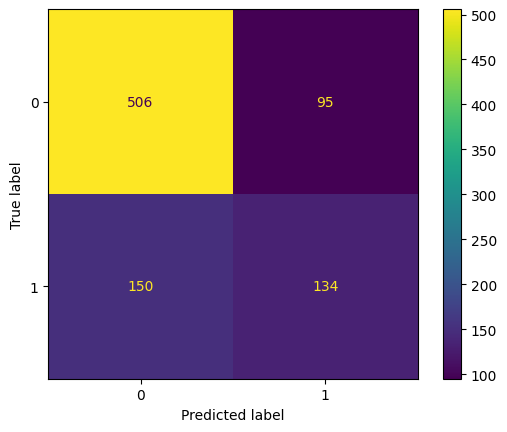

In [260]:
gboost_clf.evaluate(X_test, y_test)

### XGBoost

In [270]:
xgb_clf = Model(model_name = "XGBoost classifier", 
                estimator = XGBClassifier(),
                preprocessor = preprocess_pipe,
                scoring = "recall",
                random_state = 32)

In [271]:
xgb_clf.train(X_train, y_train)

Cross validated training results for XGBoost classifier model
---------------------------------------------------------
Train score: 0.9309554032326309 +/- 0.014148674796425668
Validation score: 0.4722853388979056 +/- 0.017437878545158485


In [273]:
param_grid = {"model__n_estimators": [100, 200, 300, 400, 500],
                "model__max_depth": [5, 10, 15, 20]}

xgb_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__max_depth': 5, 'model__n_estimators': 300}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.989 +/- 0.004287
Score of the model on the validation set:
0.501 +/- 0.031507


Recall score on test set:  0.4859154929577465
Accuracy score on test set:  0.7084745762711865

              precision    recall  f1-score   support

           0       0.77      0.81      0.79       601
           1       0.55      0.49      0.52       284

    accuracy                           0.71       885
   macro avg       0.66      0.65      0.65       885
weighted avg       0.70      0.71      0.70       885



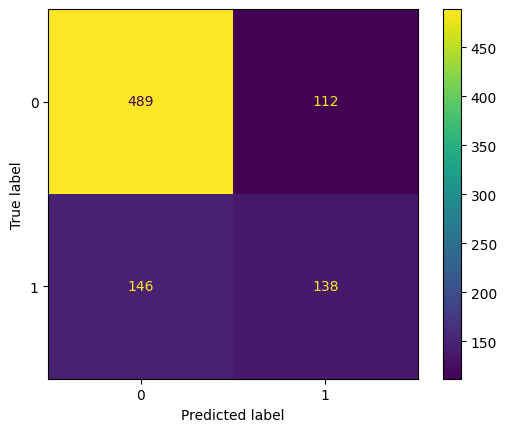

In [274]:
xgb_clf.evaluate(X_test, y_test)

## A closer look at decision tree model

In [314]:
dtree = tree_clf.fitted_model

In [315]:
from sklearn.tree import plot_tree

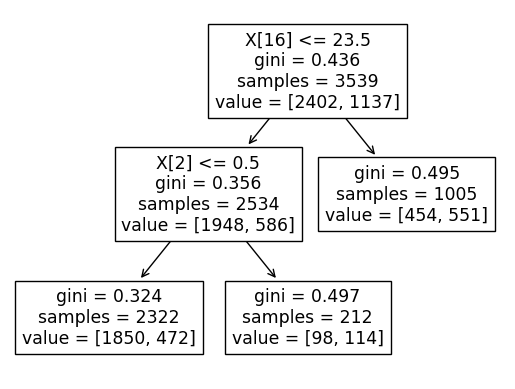

In [316]:
plot_tree(dtree[-1]);

In [317]:
columns = cat_features + num_features
importances = dtree[-1].feature_importances_
indices = np.argsort(importances)[::-1]

for index in indices:
    print(f"feature: {columns[index]}    Importance: {importances[index]}")

feature: Age at enrollment    Importance: 0.7689261552082852
feature: Debtor    Importance: 0.23107384479171475
feature: Application order    Importance: 0.0
feature: previous_qual    Importance: 0.0
feature: Gender    Importance: 0.0
feature: Scholarship holder    Importance: 0.0
feature: father_occ    Importance: 0.0
feature: mother_occ    Importance: 0.0
feature: father_qual    Importance: 0.0
feature: mother_qual    Importance: 0.0
feature: Marital status    Importance: 0.0
feature: Application mode    Importance: 0.0
feature: Attendance_mode    Importance: 0.0
feature: International    Importance: 0.0
feature: Displaced    Importance: 0.0
feature: Previous qualification (grade)    Importance: 0.0
feature: Admission grade    Importance: 0.0
feature: Course    Importance: 0.0


## Using SMOTE to oversample the minority class

In [14]:
features = cat_features + num_features
cat_mask = [True if x in features else False for x in X_train.columns]
smote = SMOTENC(categorical_features=cat_mask, random_state=32)

### Decision Tree

In [27]:
tree_os_clf = Model(model_name = "Decision tree classifier", 
                    estimator = DecisionTreeClassifier(),
                    preprocessor = preprocess_pipe,
                    sampler = smote,
                    scoring = "recall",
                    random_state = 32)

In [28]:
tree_os_clf.train(X_train, y_train)

Cross validated training results for Decision tree classifier model
---------------------------------------------------------
Train score: 1.0 +/- 0.0
Validation score: 0.5602480871782982 +/- 0.019226656807916267


Recall score on test set:  0.4894366197183099
Accuracy score on test set:  0.607909604519774

              precision    recall  f1-score   support

           0       0.73      0.66      0.70       601
           1       0.41      0.49      0.44       284

    accuracy                           0.61       885
   macro avg       0.57      0.58      0.57       885
weighted avg       0.63      0.61      0.62       885



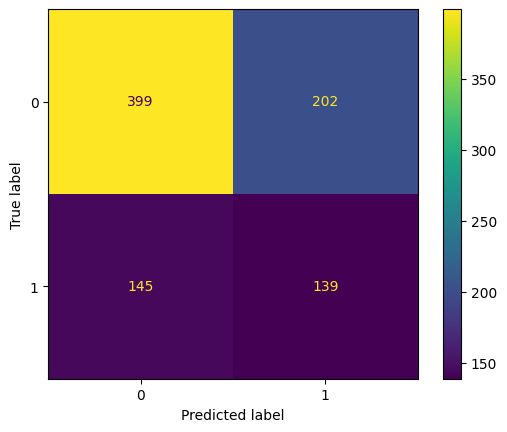

In [29]:
tree_os_clf.evaluate(X_test, y_test)

In [49]:
param_grid = {"model__max_depth": [3, 4, 5, 6, 7, 8],
                "model__min_samples_split":[2, 4, 6, 8, 10],
                "model__min_samples_leaf": [1, 2, 3, 4, 5, 6]}

tree_os_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 4}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.741 +/- 0.010271
Score of the model on the validation set:
0.724 +/- 0.025804


Recall score on test set:  0.6302816901408451
Accuracy score on test set:  0.6576271186440678

              precision    recall  f1-score   support

           0       0.79      0.67      0.73       601
           1       0.47      0.63      0.54       284

    accuracy                           0.66       885
   macro avg       0.63      0.65      0.63       885
weighted avg       0.69      0.66      0.67       885



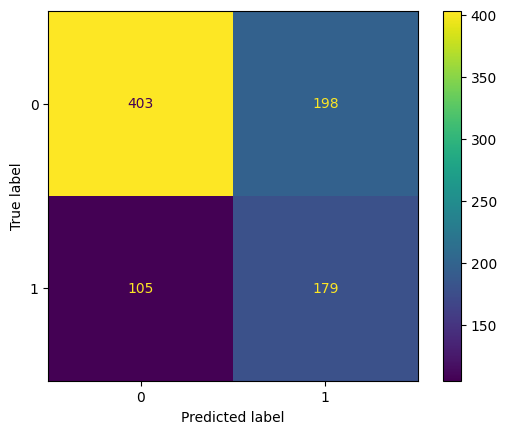

In [50]:
tree_os_clf.evaluate(X_test, y_test)

### Logistic Regression

In [52]:
logreg_os_clf = Model(model_name = "Logistic regression (over sampled) classifier", 
                    estimator = LogisticRegression(penalty = "elasticnet", solver="saga", l1_ratio=0,  max_iter=1000),
                    preprocessor = preprocess_pipe,
                    sampler = smote,
                    scoring = "recall",
                    random_state = 32)

In [53]:
logreg_os_clf.train(X_train, y_train)

Cross validated training results for Logistic regression (over sampled) classifier model
---------------------------------------------------------
Train score: 0.6976704263832977 +/- 0.003649197563145341
Validation score: 0.6930751990107427 +/- 0.022991592074380323


In [56]:
param_grid = {"model__C": [0.01, 0.1, 1, 10, 100],
            "model__l1_ratio": np.linspace(0, 1, 11)}
logreg_os_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__C': 0.1, 'model__l1_ratio': 1.0}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.698 +/- 0.006345
Score of the model on the validation set:
0.696 +/- 0.018458


Recall score on test set:  0.7253521126760564
Accuracy score on test set:  0.6779661016949152

              precision    recall  f1-score   support

           0       0.83      0.66      0.73       601
           1       0.50      0.73      0.59       284

    accuracy                           0.68       885
   macro avg       0.67      0.69      0.66       885
weighted avg       0.73      0.68      0.69       885



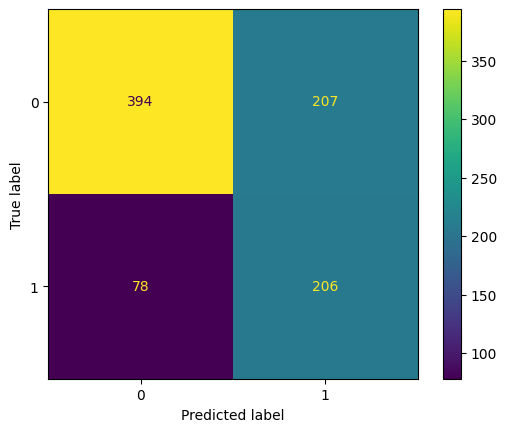

In [57]:
logreg_os_clf.evaluate(X_test, y_test)

### Random Forest

In [15]:
rf_os_clf = Model(model_name = "Random Forest (over sampled) classifier", 
                    estimator = RandomForestClassifier(),
                    preprocessor = preprocess_pipe,
                    sampler = smote,
                    scoring = "recall",
                    random_state = 32)

In [16]:
rf_os_clf.train(X_train, y_train)

Cross validated training results for Random Forest (over sampled) classifier model
---------------------------------------------------------
Train score: 1.0 +/- 0.0
Validation score: 0.5690393384341912 +/- 0.043257289603777


In [25]:
param_grid = {"model__n_estimators": [100, 200, 300, 400],
            "model__max_depth": [5, 10, 15, 20],
            "model__min_samples_split":[2, 3, 4, 5],
            "model__min_samples_leaf": [1, 2, 3, 4, 5]}

rf_os_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 3, 'model__n_estimators': 100}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.709 +/- 0.013559
Score of the model on the validation set:
0.670 +/- 0.039700


Recall score on test set:  0.6901408450704225
Accuracy score on test set:  0.6983050847457627

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       601
           1       0.52      0.69      0.59       284

    accuracy                           0.70       885
   macro avg       0.68      0.70      0.68       885
weighted avg       0.73      0.70      0.71       885



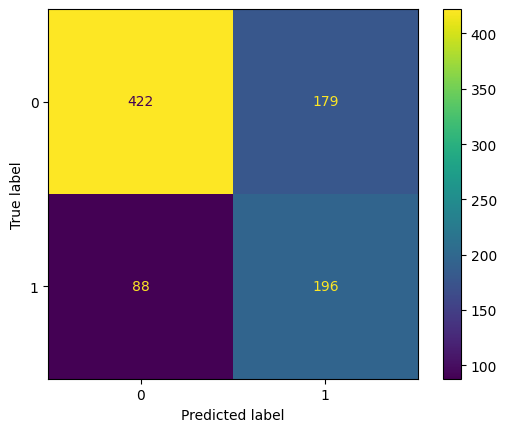

In [26]:
rf_os_clf.evaluate(X_test, y_test)

### Xgboost

In [28]:
xgb_os_clf = Model(model_name = "XGBoost classifier", 
                estimator = XGBClassifier(),
                preprocessor = preprocess_pipe,
                sampler = smote,
                scoring = "recall",
                random_state = 32)

In [29]:
xgb_os_clf.train(X_train, y_train)

Cross validated training results for XGBoost classifier model
---------------------------------------------------------
Train score: 0.9498652063008499 +/- 0.012847903385979517
Validation score: 0.5602326300332329 +/- 0.012890517613264374


In [33]:
param_grid = {"model__n_estimators": [100, 200, 300, 400, 500]}

xgb_os_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__n_estimators': 100}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.950 +/- 0.012848
Score of the model on the validation set:
0.560 +/- 0.012891


Recall score on test set:  0.5633802816901409
Accuracy score on test set:  0.6926553672316385

              precision    recall  f1-score   support

           0       0.79      0.75      0.77       601
           1       0.52      0.56      0.54       284

    accuracy                           0.69       885
   macro avg       0.65      0.66      0.65       885
weighted avg       0.70      0.69      0.70       885



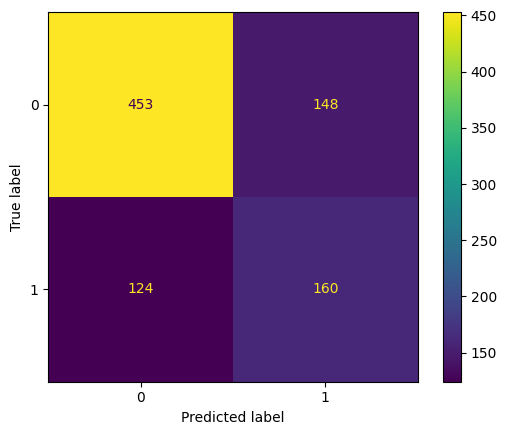

In [34]:
xgb_os_clf.evaluate(X_test, y_test)

## Best model -  Random Forest with SMOTE

In [37]:
final_rf = Model(model_name = "Random Forest with SMOTE", 
                    estimator = RandomForestClassifier(n_estimators=100,
                                                        max_depth=5,
                                                        min_samples_leaf=2,
                                                        min_samples_split=3),
                    preprocessor = preprocess_pipe,
                    sampler = smote,
                    scoring = "recall",
                    random_state = 32)

In [38]:
final_rf.train(X_train, y_train)

Cross validated training results for Random Forest with SMOTE model
---------------------------------------------------------
Train score: 0.7051431956382451 +/- 0.008304176633491403
Validation score: 0.6587835226833605 +/- 0.052715149429304255


Recall score on test set:  0.6971830985915493
Accuracy score on test set:  0.6994350282485876

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       601
           1       0.52      0.70      0.60       284

    accuracy                           0.70       885
   macro avg       0.68      0.70      0.68       885
weighted avg       0.73      0.70      0.71       885



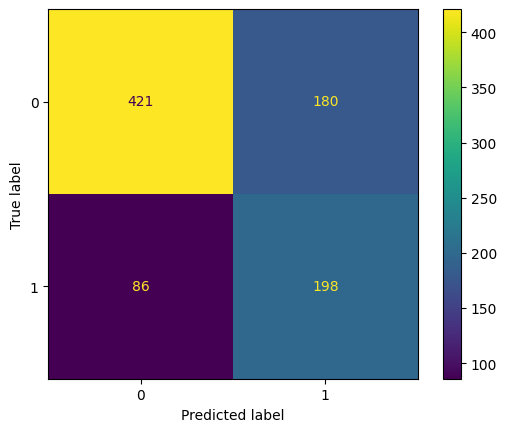

In [39]:
final_rf.evaluate(X_test, y_test)

### Feature importances

In [52]:
importance_df = pd.DataFrame()
importance_df['Feature'] = features
importance_df['Rel_importance'] = final_rf.fitted_model[-1].feature_importances_


importance_df.sort_values(by='Rel_importance', ascending=False)


,Feature,Rel_importance
4,Scholarship holder,0.235008
16,Age at enrollment,0.171246
10,Application mode,0.122997
14,Previous qualification (grade),0.090022
3,Gender,0.082122
2,Debtor,0.067062
15,Admission grade,0.056980
0,Course,0.047055
17,Application order,0.031780
6,mother_occ,0.019145


In [53]:
import seaborn as sns

Text(0.5, 1.0, 'Random Forest model - Feature Importance')

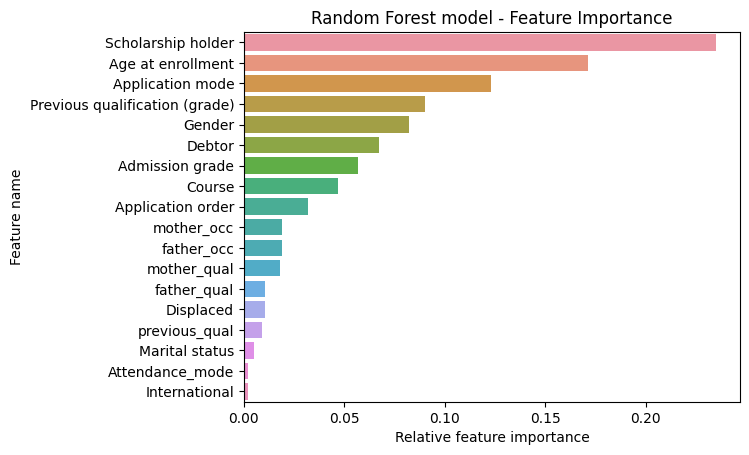

In [58]:
sns.barplot(data=importance_df.sort_values(by='Rel_importance', ascending=False), y = 'Feature', x = 'Rel_importance')
plt.xlabel("Relative feature importance")
plt.ylabel("Feature name")
plt.title("Random Forest model - Feature Importance")